In [ ]:
%pip install pandas
%pip install numpy
%pip install sklearn
%pip install matplotlib

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, confusion_matrix
from sklearn.svm import OneClassSVM
import copy

# How big is train dataset ?
train_test_ratio = 0.039
np.random.RandomState(seed=42)

data_path = os.path.abspath(os.path.join(os.getcwd(), '..',  'dataset'))

names = pd.read_csv(os.path.join(data_path, 'NUSW-NB15_features_v2.csv'))['Name'].tolist()

frames = []

frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_1.csv"), names=names))
# Uncomment to load all csv
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_2.csv"), names=names))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_3.csv"), names=names))
frames.append(pd.read_csv(os.path.join(data_path, "UNSW-NB15_4.csv"), names=names))

df = pd.concat(frames, axis=0, ignore_index=True)

mask = np.random.rand(len(df)) < train_test_ratio
train = df[mask]
test = df[~mask]

# Clear memory
del df

train.head()

In [3]:
# Info about data types and columns
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99182 entries, 30 to 2540041
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   srcip             99182 non-null  object 
 1   sport             99182 non-null  object 
 2   dstip             99182 non-null  object 
 3   dsport            99182 non-null  object 
 4   proto             99182 non-null  object 
 5   state             99182 non-null  object 
 6   dur               99182 non-null  float64
 7   sbytes            99182 non-null  int64  
 8   dbytes            99182 non-null  int64  
 9   sttl              99182 non-null  int64  
 10  dttl              99182 non-null  int64  
 11  sloss             99182 non-null  int64  
 12  dloss             99182 non-null  int64  
 13  service           99182 non-null  object 
 14  Sload             99182 non-null  float64
 15  Dload             99182 non-null  float64
 16  Spkts             99182 non-null  int

In [4]:
# Count null values in columns
train.isnull().sum()

srcip                   0
sport                   0
dstip                   0
dsport                  0
proto                   0
state                   0
dur                     0
sbytes                  0
dbytes                  0
sttl                    0
dttl                    0
sloss                   0
dloss                   0
service                 0
Sload                   0
Dload                   0
Spkts                   0
Dpkts                   0
swin                    0
dwin                    0
stcpb                   0
dtcpb                   0
smeansz                 0
dmeansz                 0
trans_depth             0
res_bdy_len             0
Sjit                    0
Djit                    0
Stime                   0
Ltime                   0
Sintpkt                 0
Dintpkt                 0
tcprtt                  0
synack                  0
ackdat                  0
is_sm_ips_ports         0
ct_state_ttl            0
ct_flw_http_mthd    52459
is_ftp_login

In [5]:
# How many attacks and normal records do we have ?
train['Label'].value_counts()

0    86597
1    12585
Name: Label, dtype: int64

<BarContainer object of 40 artists>

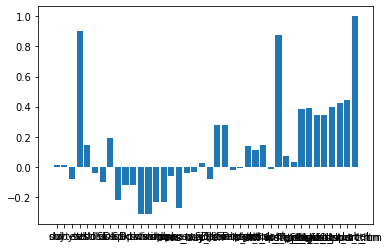

In [6]:
correlation = train.corr()['Label']

plt.bar(correlation.keys(), correlation.tolist())
# plt.show()

In [7]:
corr_dict = correlation.to_dict()
correlation_treshold = 0.2

# Return column names where correlation is greater or equal than threshold
column_names = [key for key, value in corr_dict.items() if abs(value) >= correlation_treshold]
column_names.remove('Label')
column_names

['sttl',
 'Dload',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'dmeansz',
 'Stime',
 'Ltime',
 'ct_state_ttl',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm']

In [8]:
X_train = train[column_names]
y_train = train['Label']
# del train

X_test = test[column_names]
y_test = test['Label']
# del test

In [10]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [11]:
y_pred = clf.predict(X_test)

In [12]:
print(f"SVM F1-score: {f1_score(y_test, y_pred)}")
print(f"SVM accuracy: {accuracy_score(y_test, y_pred)}")
print(f"SVM average precision: {average_precision_score(y_test, y_pred)}")

SVM F1-score: 0.9544176772719672
SVM accuracy: 0.9880492418267933
SVM average precision: 0.9134089524114917


In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

TP: 305396
TN: 2106366
FP: 25826
FN: 3345 <- attacks not detected


# Random forest classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
clf = make_pipeline(StandardScaler(), RandomForestClassifier())
# clf = RandomForestClassifier()
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [15]:
y_pred = clf.predict(X_test)
print(f"SVM F1-score: {f1_score(y_test, y_pred)}")
print(f"SVM accuracy: {accuracy_score(y_test, y_pred)}")
print(f"SVM average precision: {average_precision_score(y_test, y_pred)}")

SVM F1-score: 0.9677861681688172
SVM accuracy: 0.9918191117904506
SVM average precision: 0.9402215840175266


In [16]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

TP: 299960
TN: 2121004
FP: 11188
FN: 8781 <- attacks not detected


### Random forest has better f1-score than SVM, although for me SVM is better, because it has less FN (not detected attacks)

# One Class SVM

Getting highly correlated features to reduce time for training.

In [28]:
corr_dict = correlation.to_dict()
correlation_treshold_for_OCSVM = 0.6

# Return column names where correlation is greater or equal than threshold
column_names_for_OCSVM = [key for key, value in corr_dict.items() if abs(value) >= correlation_treshold_for_OCSVM]
column_names_for_OCSVM.remove('Label')
column_names_for_OCSVM = [  'dwin',
                            'stcpb',
                            'dtcpb'] # changed for testing

## OCSVM trained on full set of data

OCSVM model trained on both attack and not attack data. It should create a model that labels attacks as outliers (gives them -1).

In [29]:
# svm One Class

# Load data
x_train = train[column_names_for_OCSVM]
x_test = test[column_names_for_OCSVM]

one_class_svm = OneClassSVM(gamma='auto')
output = one_class_svm.fit_predict(x_train)

In [21]:
new_output = copy.deepcopy(output)

for count, out in enumerate(output):
    if out == -1:
        new_output[count] = 1
    else:
        new_output[count] = 0

In [23]:
y_train_output = train['Label']

tn, fp, fn, tp = confusion_matrix(new_output, y_train_output).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

TP: 12542
TN: 0
FP: 0
FN: 86572 <- attacks not detected


Model does not detect attacks.

In [26]:
y_test_output = one_class_svm.predict(test[column_names_for_OCSVM])

In [27]:
# Good train data (no attacks)

x_train_no_attacts = train[train['Label'] == 0]

x_train_no_attacts = x_train_no_attacts[column_names_for_OCSVM]

one_class_svm_only_good_data = OneClassSVM(gamma='auto')
output_only_good_data = one_class_svm_only_good_data.fit(x_train_no_attacts)

x_train_no_attacts


,sttl,ct_state_ttl
30,31,0
76,31,0
114,31,0
141,31,0
150,31,0
...,...,...
2539932,31,0
2539942,31,0
2540032,31,0
2540039,31,0


In [24]:
# test OCSVM that was trained only on good data

y_test_output_good_data = one_class_svm_only_good_data.predict(test[column_names_for_OCSVM].head(10000))

y_test_output_good_data

array([-1, -1, -1, ..., -1, -1, -1])

In [25]:
new_y_test_output_good_data = copy.deepcopy(y_test_output_good_data)

for count, out in enumerate(y_test_output_good_data):
    if out == -1:
        new_y_test_output_good_data[count] = 1
    else:
        new_y_test_output_good_data[count] = 0
print(len(new_y_test_output_good_data))
print(np.sum(new_y_test_output_good_data))


10000
10000


In [26]:
y_label_good_data = test['Label'].head(10000)
tn, fp, fn, tp = confusion_matrix(y_label_good_data, new_y_test_output_good_data).ravel()
print(f"TP: {tp}")
print(f"TN: {tn}")
print(f"FP: {fp}")
print(f"FN: {fn} <- attacks not detected")

TP: 687
TN: 0
FP: 9313
FN: 0 <- attacks not detected


### Results:
One Class SVM does not detect attacks and is not suitable for detecting network attacks.
It also takes a lot of time to train for higher number of features that's why only 2 features were used for training.